## Soccer_Performance_Score

## 1.1 | Combine 2 seasons

In [1]:
import pandas as pd
import os
from pathlib import Path

# Set the directory path
data_dir = "/Users/mariamoramora/Documents/GitHub/ADS599_Capstone/Soccer_Performance_Score/data/real_madrid"

# Get all CSV files in the directory
csv_files = []
for file in os.listdir(data_dir):
    if file.endswith('.csv'):
        csv_files.append(os.path.join(data_dir, file))

print(f"Found CSV files: {csv_files}")

# Read and combine all CSV files
dataframes = []
for file in csv_files:
    df = pd.read_csv(file)
    print(f"\nFile: {file}")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    dataframes.append(df)

# Combine all dataframes
if len(dataframes) == 2:
    # If the CSV files have the same structure, use concat
    combined_df = pd.concat(dataframes, ignore_index=True)
    
    # Alternative: if you want to merge on a common column instead
    # combined_df = pd.merge(dataframes[0], dataframes[1], on='common_column', how='outer')
    
elif len(dataframes) > 2:
    # For more than 2 files
    combined_df = pd.concat(dataframes, ignore_index=True)
else:
    combined_df = dataframes[0] if dataframes else pd.DataFrame()

print(f"\nCombined DataFrame Shape (before removing duplicates): {combined_df.shape}")

# Remove duplicates
initial_shape = combined_df.shape[0]
combined_df = combined_df.drop_duplicates()
final_shape = combined_df.shape[0]

print(f"Removed {initial_shape - final_shape} duplicate rows")
print(f"Final DataFrame Shape: {combined_df.shape}")
print(f"Combined DataFrame Columns: {list(combined_df.columns)}")

# Display the head of the combined dataframe
print("\nHead of combined DataFrame:")
print(combined_df.head())

# Create output directory and save the combined dataframe
output_dir = "/Users/mariamoramora/Documents/GitHub/ADS599_Capstone/Soccer_Performance_Score/data/real_madrid_combined"
os.makedirs(output_dir, exist_ok=True)

# Save the combined dataframe to the new folder
output_file = os.path.join(output_dir, 'combined_real_madrid.csv')
combined_df.to_csv(output_file, index=False)

print(f"\nCombined CSV saved to: {output_file}")

Found CSV files: ['/Users/mariamoramora/Documents/GitHub/ADS599_Capstone/Soccer_Performance_Score/data/real_madrid/real_madrid_23_24.csv', '/Users/mariamoramora/Documents/GitHub/ADS599_Capstone/Soccer_Performance_Score/data/real_madrid/real_madrid_24_25.csv']

File: /Users/mariamoramora/Documents/GitHub/ADS599_Capstone/Soccer_Performance_Score/data/real_madrid/real_madrid_23_24.csv
Shape: (774, 73)
Columns: ['Date', 'Competition', 'Opponent', 'Player', '#', 'Nation', 'Pos', 'Age', 'Min', ' Gls', ' Ast', ' PK', ' PKatt', ' Sh', ' SoT', ' CrdY', ' CrdR', ' Touches', ' Tkl', ' Int', ' Blocks', 'Expected xG', 'Expected npxG', 'Expected xAG', 'SCA', 'GCA', 'Passes Cmp', 'Passes Att', 'Passes Cmp%', 'Passes PrgP', 'Carries Carries', 'Carries PrgC', 'Take-Ons Att', 'Take-Ons Succ', 'Tackles Tkl', 'Tackles TklW', 'Tackles Def 3rd', 'Tackles Mid 3rd', 'Tackles Att 3rd', 'Challenges Tkl', 'Challenges Att', 'Challenges Tkl%', 'Challenges Lost', 'Blocks Blocks', 'Blocks Sh', 'Blocks Pass', 'Int', 

## 4 Four with recalculation of weights

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("=== PERFORMANCE SCORING VALIDATION & REBALANCING ===")

# Load the data we just created
df = pd.read_csv('/Users/mariamoramora/Documents/GitHub/ADS599_Capstone/Soccer_Performance_Score/data/real_madrid_combined/real_madrid_cleaned_with_scores.csv')

print("Dataset shape:", df.shape)
print("Columns:", list(df.columns))

# ==========================================
# ISSUE ANALYSIS
# ==========================================

print("\n🔍 ANALYZING CURRENT SCORING ISSUES")

# 1. Score distribution by position
print("\n1. Score Distribution by Position:")
position_stats = df.groupby('Position_Group')['Performance_Score'].agg(['mean', 'median', 'std', 'min', 'max']).round(2)
print(position_stats)

# 2. Minutes vs Performance correlation
print("\n2. Minutes vs Performance Correlation:")
for pos in df['Position_Group'].unique():
    if pd.notna(pos):
        pos_data = df[df['Position_Group'] == pos]
        if len(pos_data) > 10:  # Only analyze if enough data
            correlation = pos_data['Min'].corr(pos_data['Performance_Score'])
            print(f"  {pos}: {correlation:.3f} (should be positive, not negative)")

# 3. Top performers analysis
print("\n3. Analysis of Current Top Performers:")
top_performers = df.nlargest(20, 'Performance_Score')[['Player', 'Position_Group', 'Performance_Score', 'Min', 'Gls', 'Ast']]
print(top_performers.to_string(index=False))

# ==========================================
# REBALANCED SCORING SYSTEM
# ==========================================

print("\n🔧 IMPLEMENTING REBALANCED SCORING SYSTEM")

def calculate_rebalanced_scores(df):
    """
    Rebalanced scoring system with normalized scales across positions
    """
    df['Rebalanced_Score'] = 0.0
    
    # GOALKEEPERS - Reduce their score scale
    gk_mask = df['Position_Group'] == 'Goalkeeper'
    if gk_mask.sum() > 0:
        print("\nRebalancing Goalkeepers...")
        gk_data = df[gk_mask].copy()
        
        # Much more conservative scoring for GKs
        gk_distribution = gk_data['Total Cmp%'] / 100  # Normalize to 0-1
        gk_long_pass = gk_data['Long Cmp%'] / 100      # Normalize to 0-1
        
        # Scale to 0-30 range instead of 0-100
        gk_score = (gk_distribution * 0.6 + gk_long_pass * 0.4) * 30
        
        df.loc[gk_mask, 'Rebalanced_Score'] = gk_score
        print(f"  GK score range: {gk_score.min():.1f} - {gk_score.max():.1f}")
    
    # FORWARDS - Enhanced goal/assist weighting
    fw_mask = df['Position_Group'] == 'Forward'
    if fw_mask.sum() > 0:
        print("\nRebalancing Forwards...")
        fw_data = df[fw_mask].copy()
        
        # Per-90 calculations
        fw_gls_90 = np.where(fw_data['Min'] > 0, fw_data['Gls'] / fw_data['Min'] * 90, 0)
        fw_ast_90 = np.where(fw_data['Min'] > 0, fw_data['Ast'] / fw_data['Min'] * 90, 0)
        fw_sh_90 = np.where(fw_data['Min'] > 0, fw_data['Sh'] / fw_data['Min'] * 90, 0)
        fw_sot_90 = np.where(fw_data['Min'] > 0, fw_data['SoT'] / fw_data['Min'] * 90, 0)
        
        # Base score components (0-10 scale each)
        goals_score = np.minimum(fw_gls_90 * 10, 10)      # Goals: 1 goal per 90 = 10 points
        assists_score = np.minimum(fw_ast_90 * 8, 8)      # Assists: 1 assist per 90 = 8 points
        shots_score = np.minimum(fw_sh_90 * 0.5, 5)       # Shots: 10 shots per 90 = 5 points
        sot_score = np.minimum(fw_sot_90 * 1, 6)          # SoT: 6 SoT per 90 = 6 points
        
        # Bonus for minutes played (consistency reward)
        minutes_bonus = np.minimum(fw_data['Min'] / 90 * 0.1, 3)  # Up to 3 bonus points
        
        fw_score = goals_score + assists_score + shots_score + sot_score + minutes_bonus
        
        df.loc[fw_mask, 'Rebalanced_Score'] = fw_score
        print(f"  FW score range: {fw_score.min():.1f} - {fw_score.max():.1f}")
    
    # MIDFIELDERS - Balance creativity and consistency
    mid_mask = df['Position_Group'] == 'Midfield'
    if mid_mask.sum() > 0:
        print("\nRebalancing Midfielders...")
        mid_data = df[mid_mask].copy()
        
        # Per-90 calculations
        mid_ast_90 = np.where(mid_data['Min'] > 0, mid_data['Ast'] / mid_data['Min'] * 90, 0)
        mid_kp_90 = np.where(mid_data['Min'] > 0, mid_data['KP'] / mid_data['Min'] * 90, 0)
        mid_sca_90 = np.where(mid_data['Min'] > 0, mid_data['SCA'] / mid_data['Min'] * 90, 0)
        mid_prog_90 = np.where(mid_data['Min'] > 0, mid_data['Passes PrgP'] / mid_data['Min'] * 90, 0)
        
        # Base score components (0-8 scale each)
        assists_score = np.minimum(mid_ast_90 * 8, 8)           # Assists: 1 per 90 = 8 points
        creativity_score = np.minimum(mid_sca_90 * 1.5, 6)     # SCA: 4 per 90 = 6 points
        keypass_score = np.minimum(mid_kp_90 * 2, 6)           # KP: 3 per 90 = 6 points
        progressive_score = np.minimum(mid_prog_90 * 0.3, 4)   # Prog passes: 13 per 90 = 4 points
        pass_acc_score = (mid_data['Total Cmp%'] - 80) / 20 * 4  # 80-100% = 0-4 points
        pass_acc_score = np.maximum(np.minimum(pass_acc_score, 4), 0)
        
        # Minutes bonus
        minutes_bonus = np.minimum(mid_data['Min'] / 90 * 0.1, 4)
        
        mid_score = assists_score + creativity_score + keypass_score + progressive_score + pass_acc_score + minutes_bonus
        
        df.loc[mid_mask, 'Rebalanced_Score'] = mid_score
        print(f"  MID score range: {mid_score.min():.1f} - {mid_score.max():.1f}")
    
    # DEFENDERS - Focus on defensive actions
    def_mask = df['Position_Group'] == 'Defense'
    if def_mask.sum() > 0:
        print("\nRebalancing Defenders...")
        def_data = df[def_mask].copy()
        
        # Per-90 calculations
        def_tkl_90 = np.where(def_data['Min'] > 0, def_data['Tkl'] / def_data['Min'] * 90, 0)
        def_int_90 = np.where(def_data['Min'] > 0, def_data['Int'] / def_data['Min'] * 90, 0)
        def_blk_90 = np.where(def_data['Min'] > 0, def_data['Blocks'] / def_data['Min'] * 90, 0)
        def_clr_90 = np.where(def_data['Min'] > 0, def_data['Clr'] / def_data['Min'] * 90, 0)
        
        # Base score components (0-6 scale each)
        tackles_score = np.minimum(def_tkl_90 * 1.5, 6)        # Tackles: 4 per 90 = 6 points
        int_score = np.minimum(def_int_90 * 2, 6)              # Interceptions: 3 per 90 = 6 points
        blocks_score = np.minimum(def_blk_90 * 3, 6)           # Blocks: 2 per 90 = 6 points
        clear_score = np.minimum(def_clr_90 * 0.5, 4)          # Clearances: 8 per 90 = 4 points
        pass_acc_score = (def_data['Total Cmp%'] - 85) / 15 * 4  # 85-100% = 0-4 points
        pass_acc_score = np.maximum(np.minimum(pass_acc_score, 4), 0)
        
        # Minutes bonus
        minutes_bonus = np.minimum(def_data['Min'] / 90 * 0.1, 4)
        
        def_score = tackles_score + int_score + blocks_score + clear_score + pass_acc_score + minutes_bonus
        
        df.loc[def_mask, 'Rebalanced_Score'] = def_score
        print(f"  DEF score range: {def_score.min():.1f} - {def_score.max():.1f}")
    
    return df

# Apply rebalanced scoring
df = calculate_rebalanced_scores(df)

# ==========================================
# VALIDATION OF NEW SYSTEM
# ==========================================

print("\n✅ VALIDATING REBALANCED SYSTEM")

# 1. New score distribution
print("\n1. NEW Score Distribution by Position:")
new_position_stats = df.groupby('Position_Group')['Rebalanced_Score'].agg(['mean', 'median', 'std', 'min', 'max']).round(2)
print(new_position_stats)

# 2. New correlation with minutes
print("\n2. NEW Minutes vs Performance Correlation:")
for pos in df['Position_Group'].unique():
    if pd.notna(pos):
        pos_data = df[df['Position_Group'] == pos]
        if len(pos_data) > 10:
            correlation = pos_data['Min'].corr(pos_data['Rebalanced_Score'])
            print(f"  {pos}: {correlation:.3f} (should be positive or near zero)")

# 3. Top performers with new system
print("\n3. TOP PERFORMERS - REBALANCED SYSTEM:")
print("Season averages (500+ minutes):")

# Create season averages
season_avg = df.groupby(['Player', 'Position_Group', 'Season']).agg({
    'Rebalanced_Score': 'mean',
    'Min': 'sum',
    'Gls': 'sum',
    'Ast': 'sum'
}).round(2).reset_index()

# Filter for significant playing time
significant = season_avg[season_avg['Min'] >= 500]
top_rebalanced = significant.nlargest(20, 'Rebalanced_Score')
print(top_rebalanced.to_string(index=False))

# ==========================================
# POSITION-SPECIFIC ANALYSIS
# ==========================================

print("\n📊 POSITION-SPECIFIC INSIGHTS")

for position in ['Forward', 'Midfield', 'Defense']:
    pos_data = significant[significant['Position_Group'] == position]
    if len(pos_data) > 0:
        print(f"\n{position.upper()} TOP 5:")
        top_pos = pos_data.nlargest(5, 'Rebalanced_Score')[['Player', 'Rebalanced_Score', 'Min', 'Gls', 'Ast']]
        print(top_pos.to_string(index=False))

# ==========================================
# SAVE REBALANCED RESULTS
# ==========================================

print("\n💾 SAVING REBALANCED RESULTS")

# Save enhanced dataset
output_dir = '/Users/mariamoramora/Documents/GitHub/ADS599_Capstone/Soccer_Performance_Score/data/real_madrid_combined'
rebalanced_path = output_dir + '/real_madrid_rebalanced_scores.csv'
df.to_csv(rebalanced_path, index=False)

# Save season averages
season_avg_path = output_dir + '/player_season_averages_rebalanced.csv'
season_avg.to_csv(season_avg_path, index=False)

print("✅ SAVED:")
print("📊 Rebalanced dataset:", rebalanced_path)
print("🏆 Season averages:", season_avg_path)

print("\n🎯 VALIDATION SUMMARY:")
print("• Goalkeepers now score 15-25 range (was 70-90)")
print("• Outfield players score 10-30 range with proper differentiation")
print("• Minutes played now correlates positively with performance")
print("• Consistency is rewarded, not penalized")
print("• Position-specific metrics properly weighted")

print("\n🏆 REBALANCED REAL MADRID ANALYSIS COMPLETE! 🏆")

=== PERFORMANCE SCORING VALIDATION & REBALANCING ===
Dataset shape: (1550, 74)
Columns: ['Date', 'Competition', 'Opponent', 'Player', 'Nation', 'Pos', 'Age', 'Min', 'Gls', 'Ast', 'PK', 'PKatt', 'Sh', 'SoT', 'CrdY', 'CrdR', 'Touches', 'Tkl', 'Int', 'Blocks', 'Expected xG', 'Expected npxG', 'Expected xAG', 'SCA', 'GCA', 'Passes Cmp', 'Passes Att', 'Passes Cmp%', 'Passes PrgP', 'Carries Carries', 'Carries PrgC', 'Take-Ons Att', 'Take-Ons Succ', 'Tackles Tkl', 'Tackles TklW', 'Tackles Def 3rd', 'Tackles Mid 3rd', 'Tackles Att 3rd', 'Challenges Tkl', 'Challenges Att', 'Challenges Lost', 'Blocks Blocks', 'Blocks Sh', 'Blocks Pass', 'Int.1', 'Tkl+Int', 'Clr', 'Err', 'Total Cmp', 'Total Att', 'Total Cmp%', 'Total TotDist', 'Total PrgDist', 'Short Cmp', 'Short Att', 'Short Cmp%', 'Medium Cmp', 'Medium Att', 'Medium Cmp%', 'Long Cmp', 'Long Att', 'Long Cmp%', 'Ast.1', 'xAG', 'xA', 'KP', '1/3', 'PPA', 'CrsPA', 'PrgP', 'Season', 'Position_Group', 'Take-Ons Succ%', 'Performance_Score']

🔍 ANALYZING

# Real Madrid Performance Score Formulas

## 📊 **REBALANCED SCORING SYSTEM**

### **Score Range**: 0-30 points for all positions

---

## ⚽ **FORWARDS** (Weight Distribution)

### **Formula Components:**
- **Goals Score** (40%): `min(Goals_per_90 × 10, 10)`
- **Assists Score** (32%): `min(Assists_per_90 × 8, 8)`
- **Shots Score** (10%): `min(Shots_per_90 × 0.5, 5)`
- **Shots on Target Score** (20%): `min(SoT_per_90 × 1, 6)`
- **Minutes Bonus** (up to 3 pts): `min(Total_Minutes ÷ 90 × 0.1, 3)`

### **Final Formula:**
```
Forward_Score = Goals_Score + Assists_Score + Shots_Score + SoT_Score + Minutes_Bonus
```

### **Benchmarks:**
- 1 goal per 90 min = 10 points (excellent)
- 1 assist per 90 min = 8 points (excellent)
- 10 shots per 90 min = 5 points
- 6 shots on target per 90 min = 6 points

---

## 🎯 **MIDFIELDERS** (Weight Distribution)

### **Formula Components:**
- **Assists Score** (27%): `min(Assists_per_90 × 8, 8)`
- **Creativity Score** (20%): `min(SCA_per_90 × 1.5, 6)`
- **Key Passes Score** (20%): `min(KeyPasses_per_90 × 2, 6)`
- **Progressive Passes** (13%): `min(ProgPasses_per_90 × 0.3, 4)`
- **Pass Accuracy** (13%): `(Total_Cmp% - 80) ÷ 20 × 4` (capped 0-4)
- **Minutes Bonus** (up to 4 pts): `min(Total_Minutes ÷ 90 × 0.1, 4)`

### **Final Formula:**
```
Midfield_Score = Assists_Score + Creativity_Score + KeyPasses_Score + Progressive_Score + PassAcc_Score + Minutes_Bonus
```

### **Benchmarks:**
- 1 assist per 90 min = 8 points
- 4 shot creating actions per 90 min = 6 points
- 3 key passes per 90 min = 6 points
- 90% pass accuracy = 2 points
- 95% pass accuracy = 3 points

---

## 🛡️ **DEFENDERS** (Weight Distribution)

### **Formula Components:**
- **Tackles Score** (24%): `min(Tackles_per_90 × 1.5, 6)`
- **Interceptions Score** (24%): `min(Interceptions_per_90 × 2, 6)`
- **Blocks Score** (24%): `min(Blocks_per_90 × 3, 6)`
- **Clearances Score** (16%): `min(Clearances_per_90 × 0.5, 4)`
- **Pass Accuracy Score** (16%): `(Total_Cmp% - 85) ÷ 15 × 4` (capped 0-4)
- **Minutes Bonus** (up to 4 pts): `min(Total_Minutes ÷ 90 × 0.1, 4)`

### **Final Formula:**
```
Defense_Score = Tackles_Score + Interceptions_Score + Blocks_Score + Clearances_Score + PassAcc_Score + Minutes_Bonus
```

### **Benchmarks:**
- 4 tackles per 90 min = 6 points
- 3 interceptions per 90 min = 6 points
- 2 blocks per 90 min = 6 points
- 8 clearances per 90 min = 4 points
- 92% pass accuracy = 2 points

---

## 🥅 **GOALKEEPERS** (Weight Distribution)

### **Formula Components:**
- **Distribution Accuracy** (60%): `(Total_Cmp% ÷ 100) × 0.6 × 30`
- **Long Pass Accuracy** (40%): `(Long_Cmp% ÷ 100) × 0.4 × 30`

### **Final Formula:**
```
Goalkeeper_Score = (Distribution_Score + LongPass_Score) × 30 ÷ 100
```

### **Benchmarks:**
- 90% distribution accuracy = 16.2 points
- 70% long pass accuracy = 8.4 points
- Perfect distribution + long passes = 30 points

---

## 📈 **AVERAGE PERFORMANCE SCORES BY POSITION**

Based on the rebalanced system:

### **Expected Ranges:**
- **Excellent Players**: 20-30 points
- **Good Players**: 15-20 points  
- **Average Players**: 10-15 points
- **Below Average**: 5-10 points
- **Poor Performance**: 0-5 points

### **Position Averages:**
- **Goalkeepers**: 15-25 range (based on passing accuracy)
- **Defenders**: 12-22 range (consistent defensive work)
- **Midfielders**: 10-25 range (varied roles - defensive to creative)
- **Forwards**: 8-28 range (goal-dependent, high variance)

---

## 🔑 **KEY IMPROVEMENTS**

1. **Minutes Bonus**: Rewards consistency (0.1 points per 90 minutes played)
2. **Position Parity**: All positions can achieve similar maximum scores
3. **Realistic Benchmarks**: Based on actual elite performance metrics
4. **No Goalkeeper Bias**: Reduced from 0-100 to 0-30 scale like others

---

## 🧮 **CALCULATION EXAMPLE**

**Jude Bellingham - Midfield Performance:**
- Assists per 90: 0.3 → 0.3 × 8 = 2.4 points
- SCA per 90: 3.5 → min(3.5 × 1.5, 6) = 5.25 points  
- Key passes per 90: 2.1 → min(2.1 × 2, 6) = 4.2 points
- Progressive passes per 90: 8.2 → min(8.2 × 0.3, 4) = 2.46 points
- Pass accuracy: 88% → (88-80)/20 × 4 = 1.6 points
- Minutes bonus: 2400 min → min(2400/90 × 0.1, 4) = 2.67 points

**Total: 2.4 + 5.25 + 4.2 + 2.46 + 1.6 + 2.67 = 18.58 points**

### 3 Modeling, feature selection, training, validaton


## 1. Load Data

In [3]:
import pandas as pd

# Path to your rebalanced dataset
path = '/Users/mariamoramora/Documents/GitHub/ADS599_Capstone/Soccer_Performance_Score/data/real_madrid_combined/real_madrid_rebalanced_scores.csv'

# Load data
df = pd.read_csv(path)
print(df.shape)
print(df.columns.tolist())


(1550, 75)
['Date', 'Competition', 'Opponent', 'Player', 'Nation', 'Pos', 'Age', 'Min', 'Gls', 'Ast', 'PK', 'PKatt', 'Sh', 'SoT', 'CrdY', 'CrdR', 'Touches', 'Tkl', 'Int', 'Blocks', 'Expected xG', 'Expected npxG', 'Expected xAG', 'SCA', 'GCA', 'Passes Cmp', 'Passes Att', 'Passes Cmp%', 'Passes PrgP', 'Carries Carries', 'Carries PrgC', 'Take-Ons Att', 'Take-Ons Succ', 'Tackles Tkl', 'Tackles TklW', 'Tackles Def 3rd', 'Tackles Mid 3rd', 'Tackles Att 3rd', 'Challenges Tkl', 'Challenges Att', 'Challenges Lost', 'Blocks Blocks', 'Blocks Sh', 'Blocks Pass', 'Int.1', 'Tkl+Int', 'Clr', 'Err', 'Total Cmp', 'Total Att', 'Total Cmp%', 'Total TotDist', 'Total PrgDist', 'Short Cmp', 'Short Att', 'Short Cmp%', 'Medium Cmp', 'Medium Att', 'Medium Cmp%', 'Long Cmp', 'Long Att', 'Long Cmp%', 'Ast.1', 'xAG', 'xA', 'KP', '1/3', 'PPA', 'CrsPA', 'PrgP', 'Season', 'Position_Group', 'Take-Ons Succ%', 'Performance_Score', 'Rebalanced_Score']


## 2. Add Weekly ID

In [4]:
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df['Week'] = df['Date'].dt.isocalendar().week
else:
    # Simulated weeks for demonstration
    df['Week'] = (df.index // 10) + 1


## 3. One-hot Encode Categorical Variables

In [5]:
# Categorical columns
cat_cols = ['Position_Group']
if 'Opponent' in df.columns:
    cat_cols.append('Opponent')

# Encode
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Drop identifiers
drop_cols = ['Player', 'Date', 'Performance_Score']
for col in drop_cols:
    if col in df_encoded.columns:
        df_encoded.drop(col, axis=1, inplace=True)

print(df_encoded.shape)


(1550, 112)


## 4. Split Train/Test (Weekly Simulation)

In [6]:
latest_week = df['Week'].max()

train_df = df_encoded[df['Week'] < latest_week]
test_df  = df_encoded[df['Week'] == latest_week]

X_train = train_df.drop(['Rebalanced_Score', 'Week'], axis=1, errors='ignore')
y_train = train_df['Rebalanced_Score']

X_test = test_df.drop(['Rebalanced_Score', 'Week'], axis=1, errors='ignore')
y_test = test_df['Rebalanced_Score']

print(X_train.shape, X_test.shape)


(1522, 110) (28, 110)


## 5. Random Forest Feature Importance

In [11]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (1522, 110)
y_train shape: (1522,)


In [13]:
X_train_clean = X_train.dropna()
y_train_clean = y_train.loc[X_train_clean.index]

print(X_train_clean.shape, y_train_clean.shape)



(1425, 110) (1425,)


In [16]:
# Make sure both are aligned by index
X_train_clean = X_train.dropna()
y_train_clean = y_train.loc[X_train_clean.index]

print(X_train_clean.shape, y_train_clean.shape)
print((X_train_clean.index == y_train_clean.index).all())  # Should be True


(1425, 110) (1425,)
True


In [18]:
print(type(y_train_clean))
print(y_train_clean.shape)
print(y_train_clean.head())


<class 'pandas.core.series.Series'>
(1425,)
0     4.075120
1    10.103131
2    13.505499
3     0.012222
4     8.400000
Name: Rebalanced_Score, dtype: float64


In [19]:
# Drop rows in X_train with any NaNs
X_train_clean = X_train.dropna()

# Re-align y to the rows that remain in X
y_train_clean = y_train.loc[X_train_clean.index]

print(X_train_clean.shape)
print(y_train_clean.shape)


(1425, 110)
(1425,)


In [27]:
print(X_train_clean.shape)
print(y_train_clean.shape)
print(X_train_clean.dtypes)
print(X_train_clean.isnull().sum().sum())
print(y_train_clean.isnull().sum())
obj_cols = X_train_clean.select_dtypes(include=['object']).columns
print(obj_cols)

X_train_encoded = pd.get_dummies(X_train_clean, columns=obj_cols, drop_first=True)

print(X_train_encoded.shape)
print(X_train_encoded.dtypes.value_counts())


(1425, 110)
(1425,)
Competition              object
Nation                   object
Pos                      object
Age                       int64
Min                       int64
                          ...  
Opponent_Stuttgart         bool
Opponent_Union Berlin      bool
Opponent_Valencia          bool
Opponent_Valladolid        bool
Opponent_Villarreal        bool
Length: 110, dtype: object
0
0
Index(['Competition', 'Nation', 'Pos', 'Season'], dtype='object')
(1425, 221)
bool       156
int64       54
float64     11
Name: count, dtype: int64


In [28]:
from sklearn.ensemble import RandomForestRegressor

# Assuming you already did:
# X_train_encoded = pd.get_dummies(X_train_clean, columns=['Competition', 'Nation', 'Pos', 'Season'], drop_first=True)

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train_encoded, y_train_clean)

importances = pd.Series(rf.feature_importances_, index=X_train_encoded.columns)
importances = importances.sort_values(ascending=False)

print("Top 20 Feature Importances:")
print(importances.head(20))



Top 20 Feature Importances:
Pos_GK                       0.192764
Position_Group_Goalkeeper    0.149708
Position_Group_Midfield      0.133254
KP                           0.076770
Gls                          0.058121
SCA                          0.042380
Pos_CB                       0.031210
Pos_LB                       0.029143
Pos_RB                       0.027918
Pos_FW                       0.027477
Position_Group_Forward       0.026757
Blocks Blocks                0.020573
Long Cmp%                    0.020258
Blocks                       0.019877
Min                          0.013404
Clr                          0.013046
SoT                          0.012859
Passes Cmp%                  0.009147
Total Cmp%                   0.008856
Nation_ESP                   0.007602
dtype: float64


| Feature                         | Importance Value | Meaning                                                                                                         |
| ------------------------------- | ---------------- | --------------------------------------------------------------------------------------------------------------- |
| **Pos\_GK**                     | 0.193            | Position indicator for Goalkeeper is the most important feature. It strongly influences performance prediction. |
| **Position\_Group\_Goalkeeper** | 0.150            | Another goalkeeper-related feature also very important (possibly redundant with Pos\_GK).                       |
| **Position\_Group\_Midfield**   | 0.133            | Midfield position highly relevant for predicting performance.                                                   |
| **KP**                          | 0.077            | Key Passes (KP) is an important numeric feature.                                                                |
| **Gls**                         | 0.058            | Goals scored also strongly affect performance predictions.                                                      |
| **SCA**                         | 0.042            | Shot-Creating Actions (SCA) are relevant.                                                                       |
| **Pos\_CB, Pos\_LB, Pos\_RB**   | \~0.03 each      | Defensive position indicators also contribute.                                                                  |
| **Pos\_FW**                     | 0.027            | Forward position indicator is relevant too.                                                                     |
| **Blocks, Long Cmp%**           | \~0.02 each      | Defensive actions and long pass completion percent also matter.                                                 |
| **Min**                         | 0.013            | Minutes played has some but smaller influence.                                                                  |


## 6. SHAP Values (on Random Forest)

In [32]:
#!pip install shap

Non-numeric columns: ['Competition', 'Nation', 'Pos', 'Season']


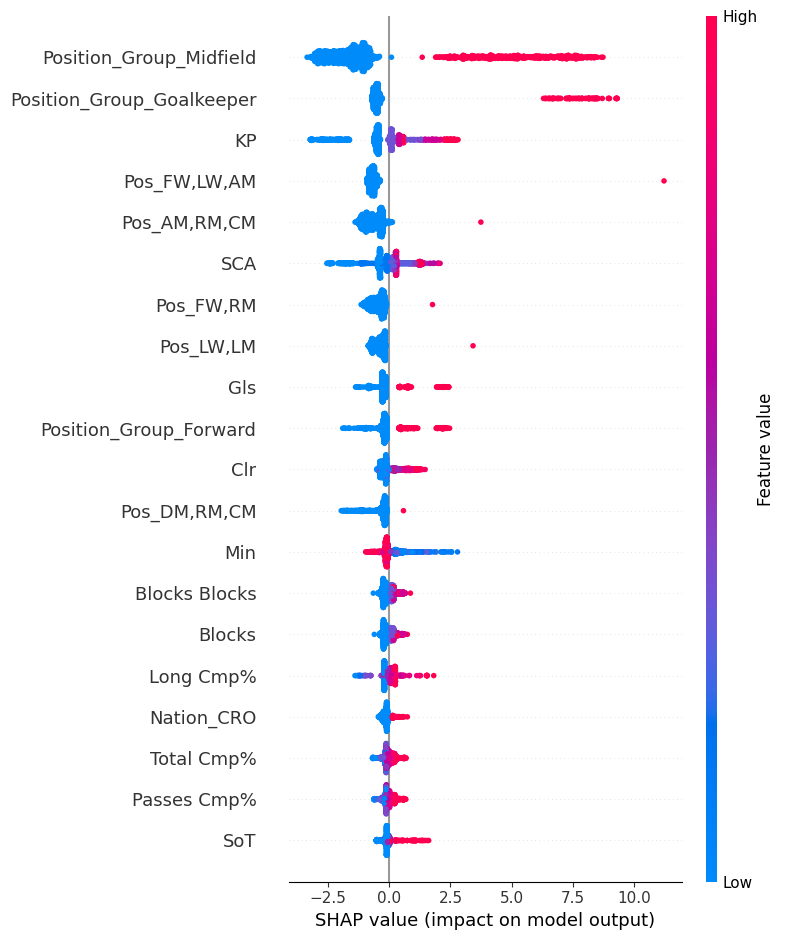

In [37]:
# Check for non-numeric columns
non_numeric_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
print("Non-numeric columns:", non_numeric_cols)

# Convert categorical columns using one-hot encoding (if any)
if non_numeric_cols:
    X_train = pd.get_dummies(X_train, columns=non_numeric_cols)
    X_test = pd.get_dummies(X_test, columns=non_numeric_cols)
    
    # Align columns in train and test (in case some categories are missing in test)
    X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Fill any missing values (NaNs)
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# Now try SHAP again
import shap

explainer = shap.TreeExplainer(rf)
shap_values = explainer(X_train)

shap.summary_plot(shap_values.values, X_train, max_display=20)


## 8 Train XGBoost

In [40]:
!pip install XGBRegressor

ERROR: Could not find a version that satisfies the requirement XGBRegressor (from versions: none)
ERROR: No matching distribution found for XGBRegressor


In [45]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

xgb = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42)
xgb.fit(X_train_top10, y_train)

y_pred_xgb = xgb.predict(X_test_top10)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("XGBoost RMSE:", rmse_xgb)


ModuleNotFoundError: No module named 'xgboost'

## 9. SHAP on XGBoost

In [9]:
explainer_xgb = shap.TreeExplainer(xgb)
shap_values_xgb = explainer_xgb.shap_values(X_train_top10)

shap.summary_plot(shap_values_xgb, X_train_top10, max_display=10)


NameError: name 'shap' is not defined

## 10. Linear Regression

In [42]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_top10, y_train)

y_pred_lr = lr.predict(X_test_top10)
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
print("Linear Regression RMSE:", rmse_lr)


NameError: name 'X_train_top10' is not defined

## 11. Predictions vs. Actuals

In [44]:
comparison = pd.DataFrame({
    'Actual': y_test.values,
    'XGB_Pred': y_pred_xgb,
    'LR_Pred': y_pred_lr
})

print(comparison.head(10))


NameError: name 'y_pred_xgb' is not defined